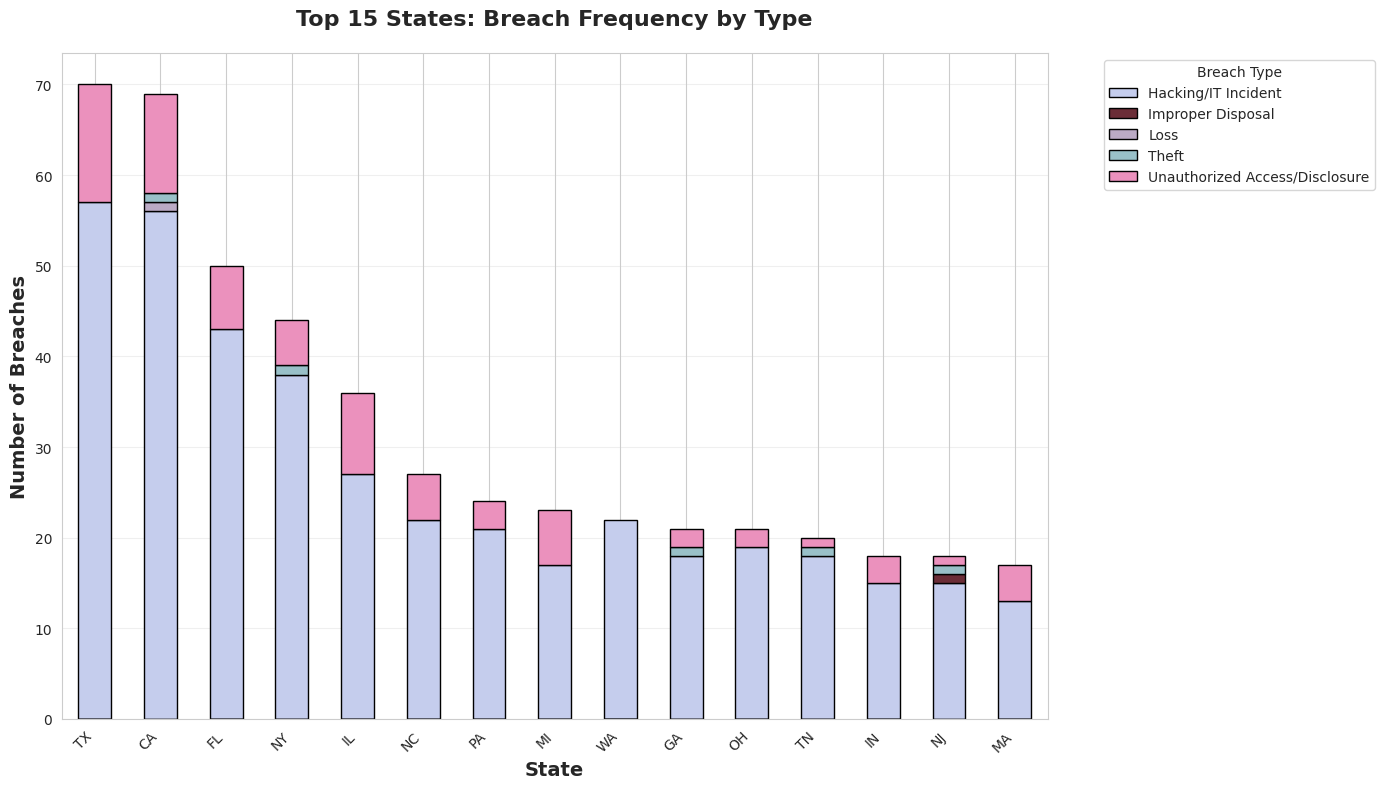

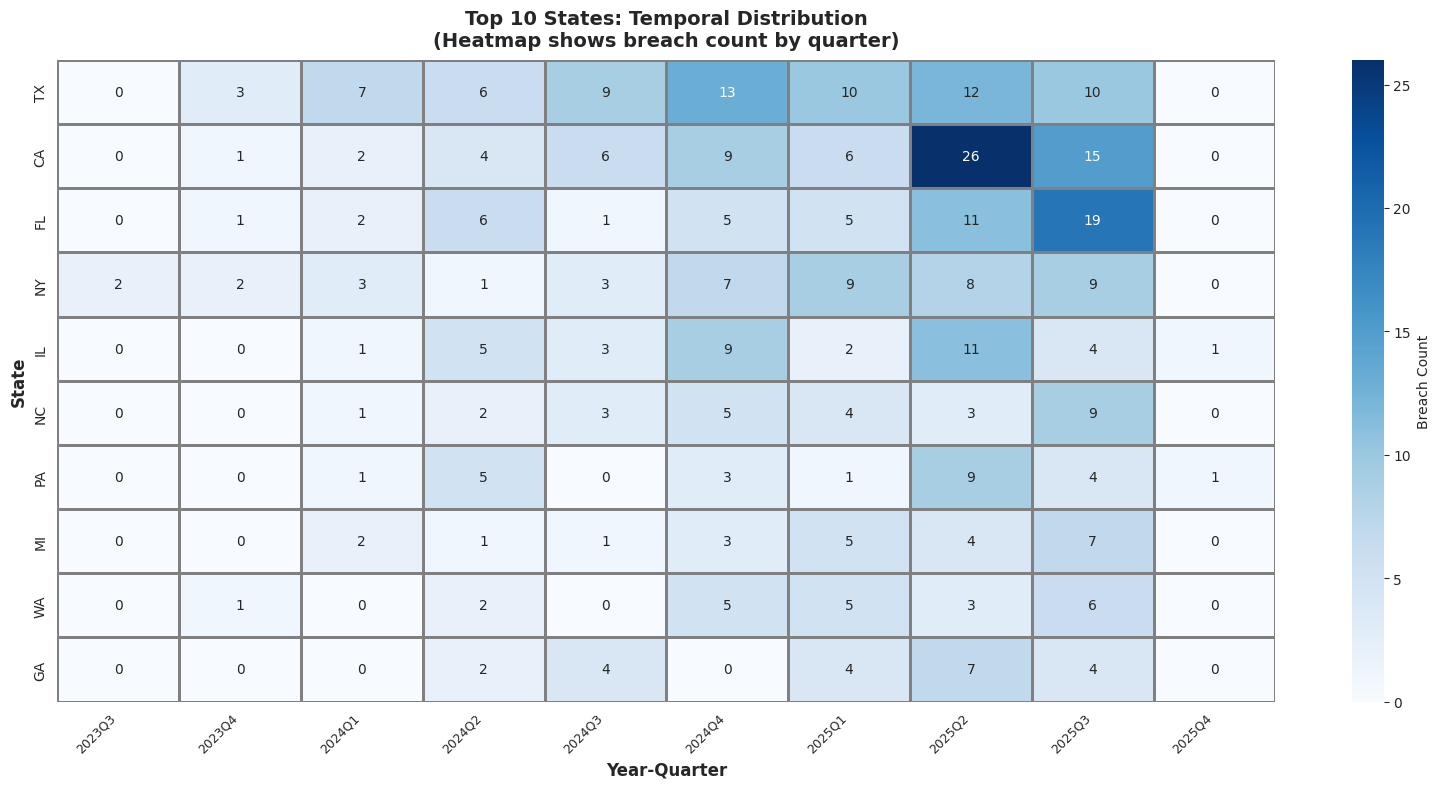

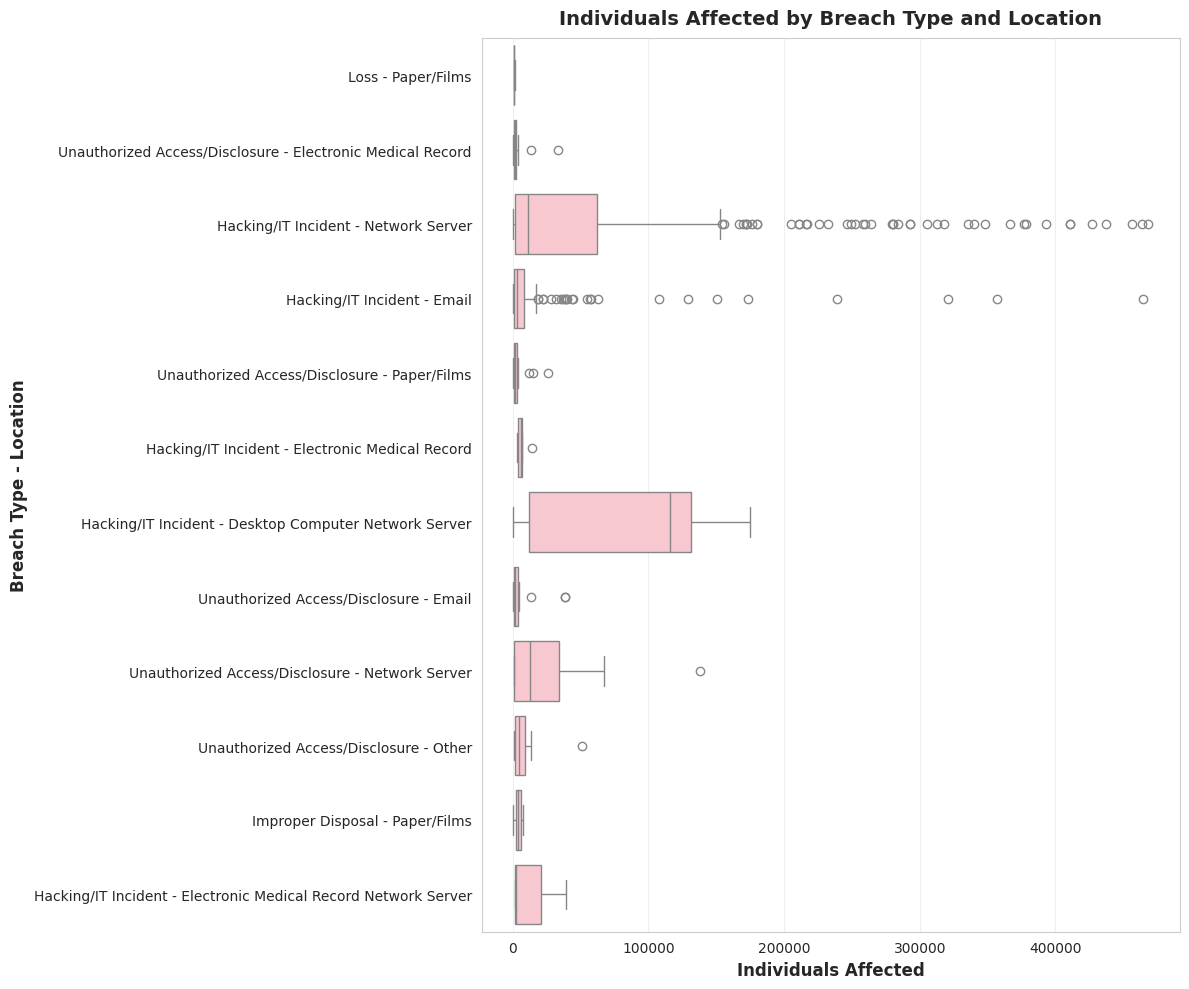

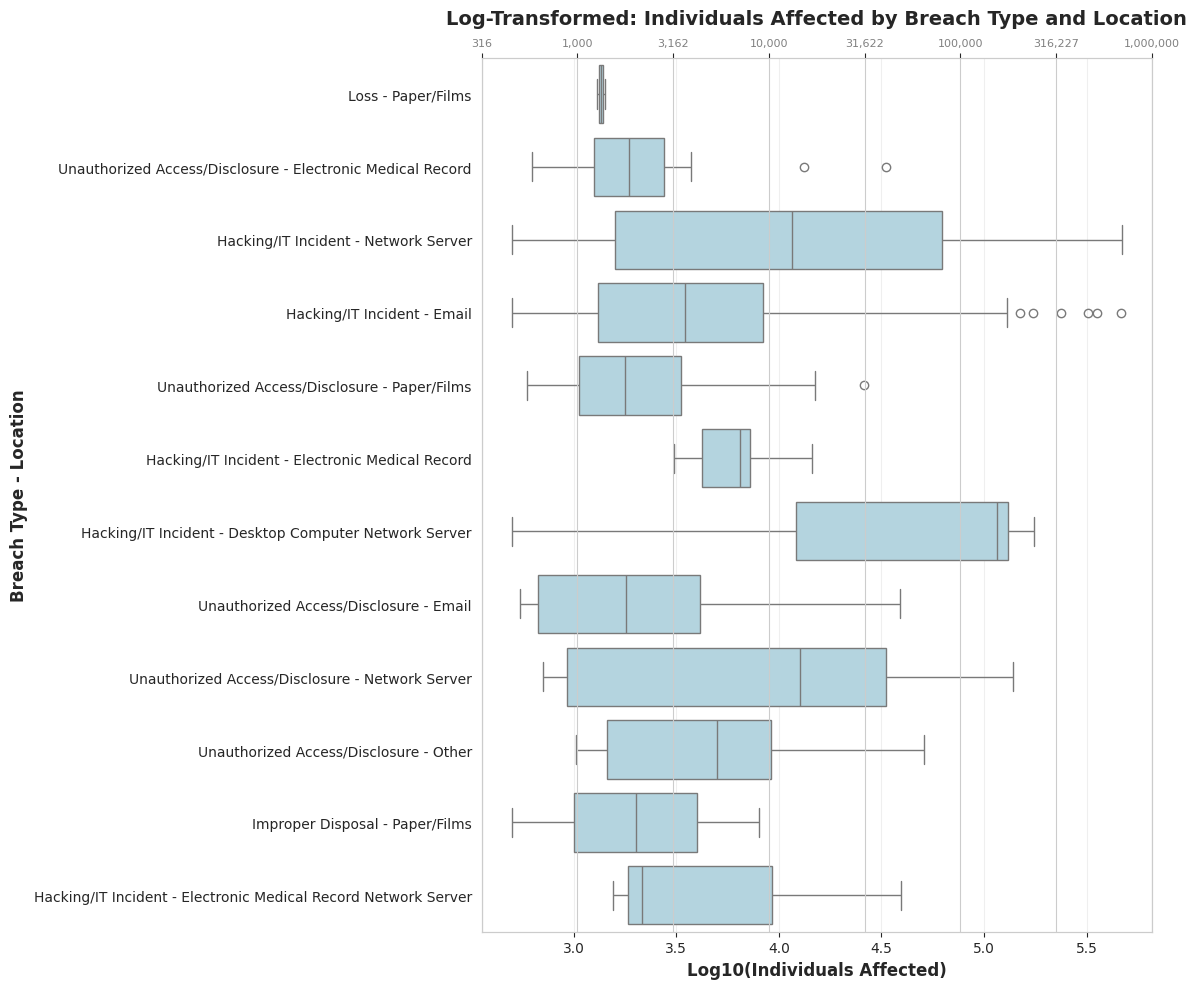

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df = pd.read_excel('breach_report.xls')
df.drop('Web Description', axis=1, inplace=True)

for col in df.columns:
    df[col] = df[col].astype(str).replace({'$': '', ',': '', '-': '', '—': ''}, regex=True)

df = df.dropna(axis=1, how='all')
df['Individuals Affected'] = pd.to_numeric(df['Individuals Affected'], errors='coerce')
df['Breach Submission Date'] = pd.to_datetime(df['Breach Submission Date'], errors='coerce')

df['State_Original'] = df['State'].copy()
df['Type_of_Breach_Original'] = df['Type of Breach'].copy()
df['Location_Original'] = df['Location of Breached Information'].copy()

encoder = LabelEncoder()
df['Location of Breached Information Encoded'] = encoder.fit_transform(df['Location of Breached Information'])
df['State Encoded'] = encoder.fit_transform(df['State'])
df['Covered Entity Type Encoded'] = encoder.fit_transform(df['Covered Entity Type'])

if 'Business Associate Present' in df.columns:
    df['Business Associate Present'] = df['Business Associate Present'].map({'Yes': 1, 'No': 0})
if 'Type of Breach' in df.columns:
    df['Type of Breach'] = df['Type of Breach'].map({'Hacking/IT Incident': 1, 'Unauthorized Access/Disclosure': 0})

#bar graph
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))

top_states = df['State_Original'].value_counts().head(15).index
state_breach = pd.crosstab(df[df['State_Original'].isin(top_states)]['State_Original'],
                           df['Type_of_Breach_Original'])
state_breach = state_breach.loc[top_states]

state_breach.plot(kind='bar', stacked=True, ax=ax,
                  color=['#c5cded', '#6b2d37', '#bbaac5', '#99c0c8', '#eb91bd'],
                  edgecolor='black', linewidth=1)

ax.set_ylabel('Number of Breaches', fontsize=14, fontweight='bold')
ax.set_xlabel('State', fontsize=14, fontweight='bold')
ax.set_title('Top 15 States: Breach Frequency by Type',
              fontsize=16, fontweight='bold', pad=20)
ax.legend(title='Breach Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
plt.close()

#heatmap
fig, ax = plt.subplots(figsize=(16, 8))

top_10_states = df['State_Original'].value_counts().head(10).index
df_top10 = df[df['State_Original'].isin(top_10_states)].copy()
df_top10['Year_Quarter'] = df_top10['Breach Submission Date'].dt.to_period('Q').astype(str)

state_time = pd.crosstab(df_top10['State_Original'], df_top10['Year_Quarter'])
state_time = state_time.loc[top_10_states]

sns.heatmap(state_time, annot=True, fmt='d', cmap='Blues',
            cbar_kws={'label': 'Breach Count'}, ax=ax,
            linewidths=1, linecolor='gray')
ax.set_xlabel('Year-Quarter', fontsize=12, fontweight='bold')
ax.set_ylabel('State', fontsize=12, fontweight='bold')
ax.set_title('Top 10 States: Temporal Distribution\n(Heatmap shows breach count by quarter)',
              fontsize=14, fontweight='bold', pad=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()
plt.close()

#box plot
fig, ax = plt.subplots(figsize=(12, 10))

df_clean = df[df['Individuals Affected'] <= df['Individuals Affected'].quantile(0.95)].copy()

df_clean['Breach_Location_Combo'] = df_clean['Type_of_Breach_Original'] + ' - ' + df_clean['Location_Original']

top_combos = df_clean['Breach_Location_Combo'].value_counts().head(12).index
df_filtered = df_clean[df_clean['Breach_Location_Combo'].isin(top_combos)]

sns.boxplot(data=df_filtered, y='Breach_Location_Combo', x='Individuals Affected',
            color='pink', ax=ax, orient='h')
ax.set_xlabel('Individuals Affected', fontsize=12, fontweight='bold')
ax.set_ylabel('Breach Type - Location', fontsize=12, fontweight='bold')
ax.set_title('Individuals Affected by Breach Type and Location',
              fontsize=14, fontweight='bold', pad=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

#log plot
fig, ax = plt.subplots(figsize=(12, 10))

df_log = df_filtered[df_filtered['Individuals Affected'] > 0].copy()
df_log['Log_Individuals_Affected'] = np.log10(df_log['Individuals Affected'])

sns.boxplot(data=df_log, y='Breach_Location_Combo', x='Log_Individuals_Affected',
            color='lightblue', ax=ax, orient='h')
ax.set_xlabel('Log10(Individuals Affected)', fontsize=12, fontweight='bold')
ax.set_ylabel('Breach Type - Location', fontsize=12, fontweight='bold')
ax.set_title('Log-Transformed: Individuals Affected by Breach Type and Location',
              fontsize=14, fontweight='bold', pad=10)
ax.grid(axis='x', alpha=0.3)

ax2 = ax.twiny()
log_ticks = ax.get_xticks()
actual_values = [f'{int(10**tick):,}' for tick in log_ticks]
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(log_ticks)
ax2.set_xticklabels(actual_values, fontsize=8, color='gray')

plt.tight_layout()
plt.show()
plt.close()
